In [151]:
import math
import warnings

from IPython.display import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
from scipy import stats
import statsmodels.formula.api as smf
from sklearn import neighbors
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.decomposition import PCA

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

In [152]:
#Import our pricing data
prices_df = pd.read_csv('kc_house_data.csv')
prices_df.head(10)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.000,3,1.000,1180,5650,1.000,0,0,...,7,1180,0,1955,0,98178,47.511,-122.257,1340,5650
1,6414100192,20141209T000000,538000.000,3,2.250,2570,7242,2.000,0,0,...,7,2170,400,1951,1991,98125,47.721,-122.319,1690,7639
2,5631500400,20150225T000000,180000.000,2,1.000,770,10000,1.000,0,0,...,6,770,0,1933,0,98028,47.738,-122.233,2720,8062
3,2487200875,20141209T000000,604000.000,4,3.000,1960,5000,1.000,0,0,...,7,1050,910,1965,0,98136,47.521,-122.393,1360,5000
4,1954400510,20150218T000000,510000.000,3,2.000,1680,8080,1.000,0,0,...,8,1680,0,1987,0,98074,47.617,-122.045,1800,7503
5,7237550310,20140512T000000,1225000.000,4,4.500,5420,101930,1.000,0,0,...,11,3890,1530,2001,0,98053,47.656,-122.005,4760,101930
6,1321400060,20140627T000000,257500.000,3,2.250,1715,6819,2.000,0,0,...,7,1715,0,1995,0,98003,47.310,-122.327,2238,6819
7,2008000270,20150115T000000,291850.000,3,1.500,1060,9711,1.000,0,0,...,7,1060,0,1963,0,98198,47.410,-122.315,1650,9711
8,2414600126,20150415T000000,229500.000,3,1.000,1780,7470,1.000,0,0,...,7,1050,730,1960,0,98146,47.512,-122.337,1780,8113
9,3793500160,20150312T000000,323000.000,3,2.500,1890,6560,2.000,0,0,...,7,1890,0,2003,0,98038,47.368,-122.031,2390,7570


In [153]:
#Checking to see if there is any missing data
def num_missing(x):
  return sum(x.isnull())

#Applying per column:
print("Missing values per column:")
print(prices_df.apply(num_missing, axis=0))

Missing values per column:
id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64


In [154]:
#Create an age feature that takes the age of the house since it was built or renovated
prices_df['age'] = np.where(prices_df['yr_renovated'] > 0, 2017 - prices_df['yr_renovated'], 2017 - prices_df['yr_built']) 
prices_df.head(10)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,age
0,7129300520,20141013T000000,221900.000,3,1.000,1180,5650,1.000,0,0,...,1180,0,1955,0,98178,47.511,-122.257,1340,5650,62
1,6414100192,20141209T000000,538000.000,3,2.250,2570,7242,2.000,0,0,...,2170,400,1951,1991,98125,47.721,-122.319,1690,7639,26
2,5631500400,20150225T000000,180000.000,2,1.000,770,10000,1.000,0,0,...,770,0,1933,0,98028,47.738,-122.233,2720,8062,84
3,2487200875,20141209T000000,604000.000,4,3.000,1960,5000,1.000,0,0,...,1050,910,1965,0,98136,47.521,-122.393,1360,5000,52
4,1954400510,20150218T000000,510000.000,3,2.000,1680,8080,1.000,0,0,...,1680,0,1987,0,98074,47.617,-122.045,1800,7503,30
5,7237550310,20140512T000000,1225000.000,4,4.500,5420,101930,1.000,0,0,...,3890,1530,2001,0,98053,47.656,-122.005,4760,101930,16
6,1321400060,20140627T000000,257500.000,3,2.250,1715,6819,2.000,0,0,...,1715,0,1995,0,98003,47.310,-122.327,2238,6819,22
7,2008000270,20150115T000000,291850.000,3,1.500,1060,9711,1.000,0,0,...,1060,0,1963,0,98198,47.410,-122.315,1650,9711,54
8,2414600126,20150415T000000,229500.000,3,1.000,1780,7470,1.000,0,0,...,1050,730,1960,0,98146,47.512,-122.337,1780,8113,57
9,3793500160,20150312T000000,323000.000,3,2.500,1890,6560,2.000,0,0,...,1890,0,2003,0,98038,47.368,-122.031,2390,7570,14


In [155]:
print(prices_df.describe())

                  id       price  bedrooms  bathrooms  sqft_living  \
count      21613.000   21613.000 21613.000  21613.000    21613.000   
mean  4580301520.865  540088.142     3.371      2.115     2079.900   
std   2876565571.312  367127.196     0.930      0.770      918.441   
min      1000102.000   75000.000     0.000      0.000      290.000   
25%   2123049194.000  321950.000     3.000      1.750     1427.000   
50%   3904930410.000  450000.000     3.000      2.250     1910.000   
75%   7308900445.000  645000.000     4.000      2.500     2550.000   
max   9900000190.000 7700000.000    33.000      8.000    13540.000   

         sqft_lot    floors  waterfront      view  condition    ...     \
count   21613.000 21613.000   21613.000 21613.000  21613.000    ...      
mean    15106.968     1.494       0.008     0.234      3.409    ...      
std     41420.512     0.540       0.087     0.766      0.651    ...      
min       520.000     1.000       0.000     0.000      1.000    ...      

In [156]:
#Let's Remove 33 bedrooms since it far outnumbers other data
prices_df = prices_df[prices_df.bedrooms != 33]
print(max(prices_df['bedrooms']))

11


In [157]:
prices_exp = prices_df[prices_df.price > 4000000]
prices_exp.head(15)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,age
1164,1247600105,20141020T000000,5110800.000,5,5.250,8010,45517,2.000,1,4,...,5990,2020,1999,0,98033,47.677,-122.211,3430,26788,18
1315,7558700030,20150413T000000,5300000.000,6,6.000,7390,24829,2.000,1,4,...,5000,2390,1991,0,98040,47.563,-122.210,4320,24619,26
1448,8907500070,20150413T000000,5350000.000,5,5.000,8000,23985,2.000,0,4,...,6720,1280,2009,0,98004,47.623,-122.220,4600,21750,8
2626,7738500731,20140815T000000,4500000.000,5,5.500,6640,40014,2.000,1,4,...,6350,290,2004,0,98155,47.749,-122.280,3030,23408,13
3914,9808700762,20140611T000000,7062500.000,5,4.500,10040,37325,2.000,1,2,...,7680,2360,1940,2001,98004,47.650,-122.214,3930,25449,16
4411,2470100110,20140804T000000,5570000.000,5,5.750,9200,35069,2.000,0,0,...,6200,3000,2001,0,98039,47.629,-122.233,3560,24345,16
7252,6762700020,20141013T000000,7700000.000,6,8.000,12050,27600,2.500,0,3,...,8570,3480,1910,1987,98102,47.630,-122.323,3940,8800,30
8092,1924059029,20140617T000000,4668000.000,5,6.750,9640,13068,1.000,1,4,...,4820,4820,1983,2009,98040,47.557,-122.210,3270,10454,8
8638,3835500195,20140618T000000,4489000.000,4,3.000,6430,27517,2.000,0,0,...,6430,0,2001,0,98004,47.621,-122.219,3720,14592,16
9254,9208900037,20140919T000000,6885000.000,6,7.750,9890,31374,2.000,0,4,...,8860,1030,2001,0,98039,47.630,-122.240,4540,42730,16


In [158]:
prices_df = prices_df[prices_df.price < 4000000]
print(max(prices_df['price']))

3850000.0


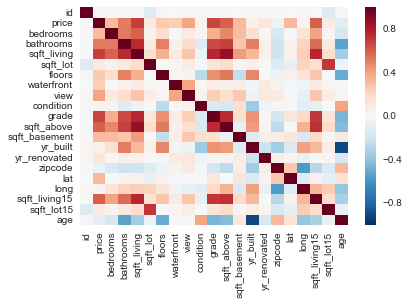

In [159]:
#See how they relate to each other
sns.heatmap(prices_df.corr())

In [160]:
#Let's take a look at the distributions to pick the best features for our model

In [161]:
prices_df['sqft_living_sqr'] = prices_df['sqft_living'] ** 2

(array([  713.,  6925.,  7853.,  4086.,  1138.,   509.,   201.,   106.,
           49.,    20.]),
 array([  273.86127875,   442.68931958,   611.51736041,   780.34540124,
          949.17344207,  1118.00148289,  1286.82952372,  1455.65756455,
         1624.48560538,  1793.31364621,  1962.14168703]),
 <a list of 10 Patch objects>)

/Users/bryancorder/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


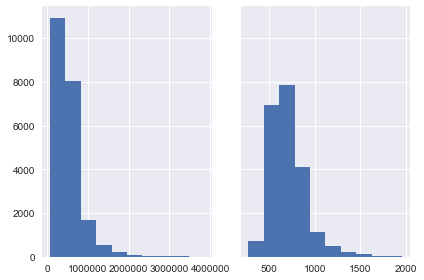

In [162]:
prices_df['price_sqrt'] = np.sqrt(prices_df['price'])

x = prices_df['price']
y = prices_df['price_sqrt']

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

# We can set the number of bins with the `bins` kwarg
axs[0].hist(x)
axs[1].hist(y)

(array([  2.12000000e+02,   2.76000000e+03,   9.82400000e+03,
          6.88000000e+03,   1.59400000e+03,   2.69000000e+02,
          3.80000000e+01,   1.30000000e+01,   6.00000000e+00,
          4.00000000e+00]),
 array([  0. ,   1.1,   2.2,   3.3,   4.4,   5.5,   6.6,   7.7,   8.8,
          9.9,  11. ]),
 <a list of 10 Patch objects>)

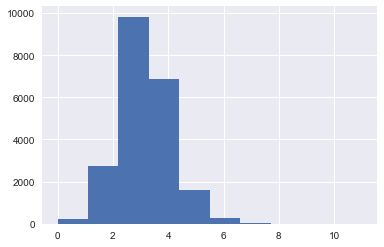

In [163]:
plt.hist(prices_df['bedrooms'])


(array([  8.60000000e+01,   5.30700000e+03,   7.02400000e+03,
          7.31700000e+03,   1.47500000e+03,   3.37000000e+02,
          4.00000000e+01,   9.00000000e+00,   3.00000000e+00,
          2.00000000e+00]),
 array([ 0. ,  0.8,  1.6,  2.4,  3.2,  4. ,  4.8,  5.6,  6.4,  7.2,  8. ]),
 <a list of 10 Patch objects>)

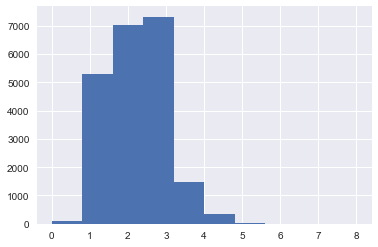

In [164]:
plt.hist(prices_df['bathrooms'])


(array([  2.50000000e+02,   4.51000000e+03,   8.75200000e+03,
          5.84000000e+03,   1.85200000e+03,   3.34000000e+02,
          5.40000000e+01,   7.00000000e+00,   0.00000000e+00,
          1.00000000e+00]),
 array([  17.02938637,   26.9625983 ,   36.89581023,   46.82902215,
          56.76223408,   66.69544601,   76.62865794,   86.56186987,
          96.4950818 ,  106.42829373,  116.36150566]),
 <a list of 10 Patch objects>)

/Users/bryancorder/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


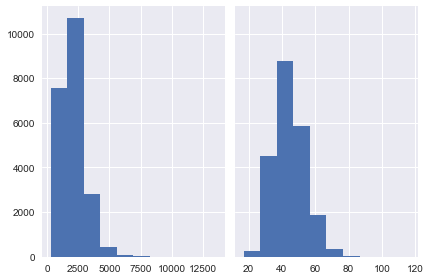

In [165]:
prices_df['sqft_living_sqrt'] = prices_df['sqft_living'] ** 0.5

x = prices_df['sqft_living']
y = prices_df['sqft_living_sqrt']

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

# We can set the number of bins with the `bins` kwarg
axs[0].hist(x)
axs[1].hist(y)


(array([    30.,      0.,      0.,    172.,      0.,  14021.,      0.,
             0.,   5677.,   1700.]),
 array([ 1.        ,  1.1236068 ,  1.2472136 ,  1.37082039,  1.49442719,
         1.61803399,  1.74164079,  1.86524758,  1.98885438,  2.11246118,
         2.23606798]),
 <a list of 10 Patch objects>)

/Users/bryancorder/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


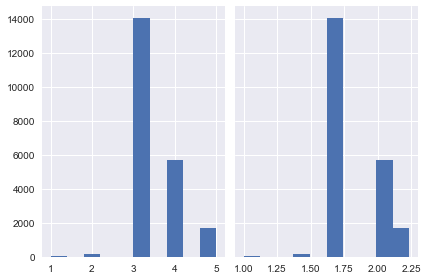

In [166]:
prices_df['condition_sqrt'] = np.sqrt(prices_df['condition'])

x = prices_df['condition']
y = prices_df['condition_sqrt']

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

# We can set the number of bins with the `bins` kwarg
axs[0].hist(x)
axs[1].hist(y)


(array([  1.31320000e+04,   3.49000000e+02,   1.19300000e+03,
          2.36000000e+03,   2.87600000e+03,   1.30500000e+03,
          3.20000000e+02,   5.80000000e+01,   5.00000000e+00,
          2.00000000e+00]),
 array([  0.        ,   6.42650761,  12.85301521,  19.27952282,
         25.70603042,  32.13253803,  38.55904563,  44.98555324,
         51.41206084,  57.83856845,  64.26507605]),
 <a list of 10 Patch objects>)

/Users/bryancorder/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


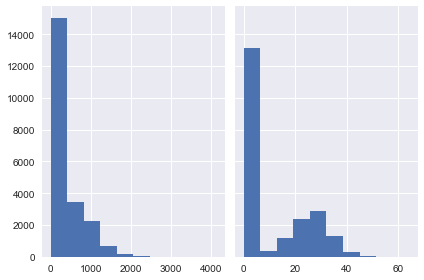

In [167]:
prices_df['sqft_basement_sqrt'] = np.sqrt(prices_df['sqft_basement'])

x = prices_df['sqft_basement']
y = prices_df['sqft_basement_sqrt'] 

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

# We can set the number of bins with the `bins` kwarg
axs[0].hist(x)
axs[1].hist(y)


(array([ 19484.,      0.,      0.,      0.,      0.,    332.,      0.,
           962.,    509.,    313.]),
 array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ]),
 <a list of 10 Patch objects>)

/Users/bryancorder/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


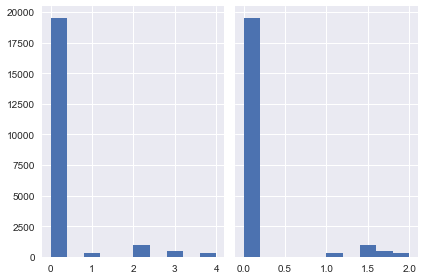

In [168]:
prices_df['view_sqrt'] = np.sqrt(prices_df['view'])

x = prices_df['view']
y = prices_df['view_sqrt']

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

# We can set the number of bins with the `bins` kwarg
axs[0].hist(x)
axs[1].hist(y)

(array([  1.06780000e+04,   0.00000000e+00,   0.00000000e+00,
          1.91000000e+03,   0.00000000e+00,   8.23100000e+03,
          0.00000000e+00,   1.60000000e+02,   6.13000000e+02,
          8.00000000e+00]),
 array([ 0.        ,  0.1252763 ,  0.25055259,  0.37582889,  0.50110519,
         0.62638148,  0.75165778,  0.87693408,  1.00221037,  1.12748667,
         1.25276297]),
 <a list of 10 Patch objects>)

/Users/bryancorder/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


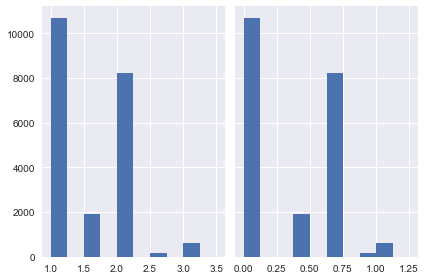

In [169]:
prices_df['floors_log'] = np.log(prices_df['floors'])

x = prices_df['floors']
y = prices_df['floors_log']

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

# We can set the number of bins with the `bins` kwarg
axs[0].hist(x)
axs[1].hist(y)

(array([ 1123.,  1390.,  2694.,  2068.,  2750.,  2932.,  3429.,  2603.,
         1379.,  1232.]),
 array([  1.41421356,   2.35445759,   3.29470162,   4.23494564,
          5.17518967,   6.11543369,   7.05567772,   7.99592175,
          8.93616577,   9.8764098 ,  10.81665383]),
 <a list of 10 Patch objects>)

/Users/bryancorder/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


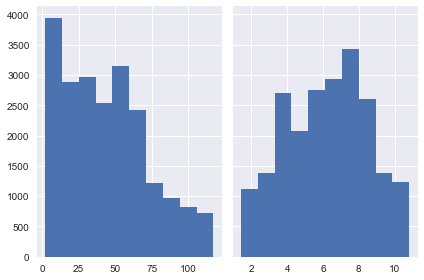

In [170]:
prices_df['age_sqrt'] = np.sqrt(prices_df['age'])

x = prices_df['age']
y = prices_df['age_sqrt']

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

# We can set the number of bins with the `bins` kwarg
axs[0].hist(x)
axs[1].hist(y)

(array([  1.00000000e+00,   3.00000000e+00,   2.90000000e+01,
          2.42000000e+02,   2.03800000e+03,   1.50480000e+04,
          2.61500000e+03,   1.13400000e+03,   3.98000000e+02,
          9.20000000e+01]),
 array([  1. ,   2.2,   3.4,   4.6,   5.8,   7. ,   8.2,   9.4,  10.6,
         11.8,  13. ]),
 <a list of 10 Patch objects>)

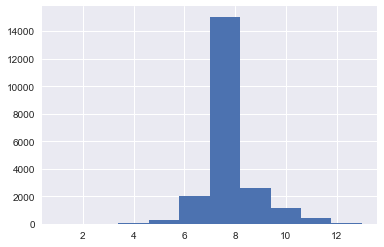

In [171]:
plt.hist(prices_df['grade'])

(array([  181.,   323.,  1411.,  1928.,  1430.,  2553.,  3890.,  3000.,
         4026.,  2858.]),
 array([ 3.85345913,  3.85476891,  3.85607869,  3.85738847,  3.85869824,
         3.86000802,  3.8613178 ,  3.86262758,  3.86393736,  3.86524713,
         3.86655691]),
 <a list of 10 Patch objects>)

/Users/bryancorder/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


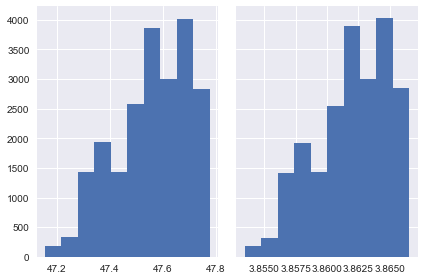

In [172]:
prices_df['lat_log'] = np.log(prices_df['lat'])

x = prices_df['lat']
y = prices_df['lat_log']

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

# We can set the number of bins with the `bins` kwarg
axs[0].hist(x)
axs[1].hist(y)

(array([  1.50000000e+01,   2.00000000e+00,   1.00000000e+00,
          2.18000000e+02,   4.83000000e+02,   2.05200000e+03,
          3.94700000e+03,   5.58200000e+03,   8.88100000e+03,
          4.19000000e+02]),
 array([ 11.01430888,  11.019761  ,  11.02521312,  11.03066525,
         11.03611737,  11.04156949,  11.04702162,  11.05247374,
         11.05792586,  11.06337799,  11.06883011]),
 <a list of 10 Patch objects>)

/Users/bryancorder/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


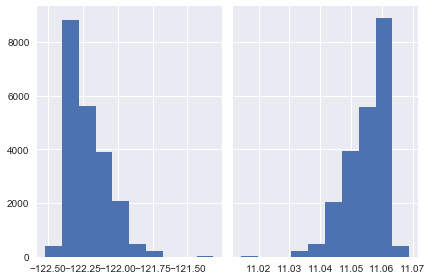

In [173]:
prices_df['long_log'] = np.sqrt(np.absolute(prices_df['long']))

x = prices_df['long']
y = prices_df['long_log']

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

# We can set the number of bins with the `bins` kwarg
axs[0].hist(x)
axs[1].hist(y)

(array([ 21442.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,    158.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

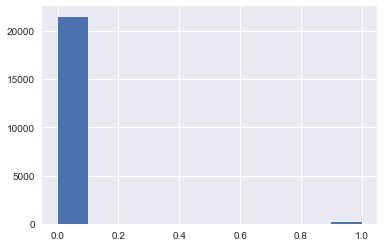

In [174]:
plt.hist(prices_df['waterfront'])

In [175]:
prices_df['latlong'] = prices_df['lat'] + np.absolute(prices_df['long'])

In [176]:
# Instantiate and fit our model with only location data
regr = linear_model.LinearRegression()
Y = prices_df['price_sqrt'].values.reshape(-1, 1)
X = prices_df[['lat', 'long', 'zipcode']]
regr.fit(X, Y)

# Inspect the results.
correlation_matrix = X.corr()
display(correlation_matrix)
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))
score = cross_val_score(regr, X, Y, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

,lat,long,zipcode
lat,1.000,-0.135,0.267
long,-0.135,1.000,-0.564
zipcode,0.267,-0.564,1.000



Coefficients: 
 [[  6.30148469e+02   1.33704213e+01  -5.84642604e-01]]

Intercept: 
 [ 29710.13548184]

R-squared:
0.180188089692
Accuracy: 0.18 (+/- 0.02)


In [177]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = prices_df['price_sqrt'].values.reshape(-1, 1)
X = prices_df[['bedrooms', 'bathrooms', 'sqft_living_sqrt', 'view_sqrt', 'floors', 'age_sqrt', 'grade', 'lat_log', 'waterfront']]
regr.fit(X, Y)

# Inspect the results.
correlation_matrix = X.corr()
display(correlation_matrix)
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))
score = cross_val_score(regr, X, Y, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

,bedrooms,bathrooms,sqft_living_sqrt,view_sqrt,floors,age_sqrt,grade,lat_log,waterfront
bedrooms,1.000,0.528,0.621,0.081,0.180,-0.163,0.364,-0.011,-0.012
bathrooms,0.528,1.000,0.763,0.181,0.502,-0.549,0.662,0.024,0.053
sqft_living_sqrt,0.621,0.763,1.000,0.264,0.366,-0.363,0.760,0.046,0.081
view_sqrt,0.081,0.181,0.264,1.000,0.024,0.030,0.246,0.007,0.334
floors,0.180,0.502,0.366,0.024,1.000,-0.564,0.458,0.049,0.023
age_sqrt,-0.163,-0.549,-0.363,0.030,-0.564,1.000,-0.464,0.116,0.007
grade,0.364,0.662,0.760,0.246,0.458,-0.464,1.000,0.114,0.075
lat_log,-0.011,0.024,0.046,0.007,0.049,0.116,0.114,1.000,-0.016
waterfront,-0.012,0.053,0.081,0.334,0.023,0.007,0.075,-0.016,1.000



Coefficients: 
 [[ -1.17179895e+01   2.22545459e+01   7.68353780e+00   5.50492136e+01
    1.12946603e+01   1.55733863e+01   6.61767896e+01   2.11896621e+04
    2.44822285e+02]]

Intercept: 
 [-82108.56469369]

R-squared:
0.730052212856
Accuracy: 0.73 (+/- 0.02)


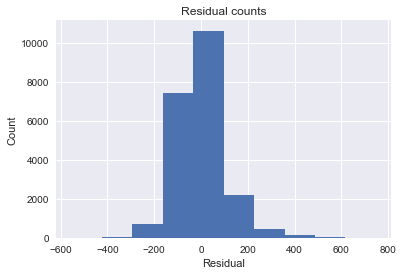

In [178]:
# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = prices_df['price_sqrt']

# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

In [179]:
# Build our model.
knn = neighbors.KNeighborsRegressor(n_neighbors=5)

X = prices_df[['bedrooms', 'bathrooms', 'sqft_living', 'view_sqrt', 'floors', 'grade',
             'lat_log', 'waterfront', 'age']] 
Y = prices_df.price_sqrt
knn.fit(X, Y)

score = cross_val_score(knn, X, Y, cv=5)
print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

Unweighted Accuracy: 0.49 (+/- 0.04)


In [180]:
# Build our model.
knn = neighbors.KNeighborsRegressor(n_neighbors=10)
X = prices_df[['bedrooms', 'bathrooms', 'sqft_living', 'view_sqrt', 'floors', 'grade',
             'lat_log', 'waterfront', 'age']] 
Y = prices_df.price_sqrt
knn.fit(X, Y)

score = cross_val_score(knn, X, Y, cv=5)
print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

Unweighted Accuracy: 0.52 (+/- 0.03)


In [181]:
# Build our model.
knn = neighbors.KNeighborsRegressor(n_neighbors=15)
X = prices_df[['bedrooms', 'bathrooms', 'sqft_living', 'view_sqrt', 'floors', 'grade',
             'lat_log', 'waterfront', 'age']] 
Y = prices_df.price_sqrt
knn.fit(X, Y)

score = cross_val_score(knn, X, Y, cv=5)
print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

Unweighted Accuracy: 0.53 (+/- 0.03)


In [182]:
# Build our model.
knn = neighbors.KNeighborsRegressor(n_neighbors=20)
X = prices_df[['bedrooms', 'bathrooms', 'sqft_living', 'view_sqrt', 'floors', 'grade',
             'lat_log', 'waterfront', 'age']] 
Y = prices_df.price_sqrt
knn.fit(X, Y)

score = cross_val_score(knn, X, Y, cv=5)
print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

Unweighted Accuracy: 0.53 (+/- 0.03)


In [183]:
# Build our model.
knn = neighbors.KNeighborsRegressor(n_neighbors=25, weights='distance')
X = prices_df[['bedrooms', 'bathrooms', 'sqft_living', 'view_sqrt', 'floors', 'grade',
             'lat_log', 'waterfront', 'age']] 
Y = prices_df.price_sqrt
knn.fit(X, Y)

score = cross_val_score(knn, X, Y, cv=5)
print("Weighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

Weighted Accuracy: 0.53 (+/- 0.03)


In [184]:
# Try only location data
prices_df['abs_long'] = np.absolute(prices_df['long'])
knn = neighbors.KNeighborsRegressor(n_neighbors=35)
X = prices_df[['lat', 'abs_long', 'sqft_living', 'zipcode']] 
Y = prices_df.price_sqrt
knn.fit(X, Y)

score = cross_val_score(knn, X, Y, cv=5)
print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

Unweighted Accuracy: 0.56 (+/- 0.04)


In [185]:
# Try only location data
knn = neighbors.KNeighborsRegressor(n_neighbors=25, weights='distance')
X = prices_df[['lat', 'abs_long', 'sqft_living', 'zipcode']] 
Y = prices_df.price_sqrt
knn.fit(X, Y)

score = cross_val_score(knn, X, Y, cv=5)
print("Weighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
# Set up our prediction line.
"""T = np.arange(0, len(prices_df), 0.1)[:, np.newaxis]

# Trailing underscores are a common convention for a prediction.
Y_ = knn.predict(T)

plt.scatter(X, Y, c='k', label='prices_df')
plt.plot(T, Y_, c='g', label='prediction')
plt.xlim(97500, 107500)
plt.legend()
plt.title('K=25, Weighted')
plt.show()"""

Weighted Accuracy: 0.62 (+/- 0.01)


"T = np.arange(0, len(prices_df), 0.1)[:, np.newaxis]\n\n# Trailing underscores are a common convention for a prediction.\nY_ = knn.predict(T)\n\nplt.scatter(X, Y, c='k', label='prices_df')\nplt.plot(T, Y_, c='g', label='prediction')\nplt.xlim(97500, 107500)\nplt.legend()\nplt.title('K=25, Weighted')\nplt.show()"

In [186]:
# Try only location data

knn = neighbors.KNeighborsRegressor(n_neighbors=35)
X = prices_df[['lat', 'abs_long', 'sqft_living', 'zipcode']] 
Y = prices_df.price_sqrt
knn.fit(X, Y)

score = cross_val_score(knn, X, Y, cv=5)
print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

Unweighted Accuracy: 0.56 (+/- 0.04)


In [187]:
#Try normalizing the data for KNN

a = prices_df['bedrooms']
b = prices_df['bathrooms']
c = prices_df['sqft_living']
d = prices_df['floors']
e = prices_df['view_sqrt']
f = prices_df['grade']
g = prices_df['lat_log']
h = prices_df['waterfront']
i = prices_df['age_sqrt']
j = prices_df['price']
h = prices_df['lat']
i = prices_df['long']
prices_df['pricenormalized'] = (j-min(j))/(max(j)-min(j))
prices_df['latnormalized'] = (h-min(h))/(max(h)-min(h))
prices_df['longnormalized'] = (i-min(i))/(max(i)-min(i))
prices_df['bedroomsnormalized'] = (a-min(a))/(max(a)-min(a))
prices_df['bathroomsnormalized'] = (b-min(b))/(max(b)-min(b))
prices_df['sqft_living_normalized'] = (c-min(c))/(max(c)-min(c))
prices_df['floorsnormalized'] = (d-min(d))/(max(d)-min(d))
prices_df['viewnormalized'] = (e-min(e))/(max(e)-min(e))
prices_df['gradenormalized'] = (f-min(f))/(max(f)-min(f))
prices_df['lat_lognormalized'] = (g-min(g))/(max(g)-min(g))
prices_df['waterfrontnormalized'] = (h-min(h))/(max(h)-min(h))
prices_df['agenormalized'] = (i-min(i))/(max(i)-min(i))

In [188]:
# Build our model.
knn = neighbors.KNeighborsRegressor(n_neighbors=25)
X = prices_df[['bedroomsnormalized', 'bathroomsnormalized', 'sqft_living_normalized',  
                  'floorsnormalized', 'viewnormalized', 'gradenormalized', 'latnormalized',
                  'waterfrontnormalized', 'agenormalized']]
Y = prices_df.price_sqrt
knn.fit(X, Y)

score = cross_val_score(knn, X, Y, cv=5)
print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
# Set up our prediction line.
"""T = np.arange(0, 6, 0.1)[:, np.newaxis]

# Trailing underscores are a common convention for a prediction.
Y_ = knn.predict(T)

plt.scatter(X, Y, c='k', label='prices_df')
plt.plot(T, Y_, c='g', label='prediction')
plt.xlim(0, 6)
plt.legend()
plt.title('K=25, Weighted')
plt.show()"""

Unweighted Accuracy: 0.84 (+/- 0.01)


"T = np.arange(0, 6, 0.1)[:, np.newaxis]\n\n# Trailing underscores are a common convention for a prediction.\nY_ = knn.predict(T)\n\nplt.scatter(X, Y, c='k', label='prices_df')\nplt.plot(T, Y_, c='g', label='prediction')\nplt.xlim(0, 6)\nplt.legend()\nplt.title('K=25, Weighted')\nplt.show()"

In [189]:
# Build our model.
knn = neighbors.KNeighborsRegressor(n_neighbors=25, weights='distance')
X = prices_df[['latnormalized', 'longnormalized']]
Y = prices_df.price
knn.fit(X, Y)

score = cross_val_score(knn, X, Y, cv=5)
print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
# Set up our prediction line.
"""T = np.arange(0, 4, 0.1)[:, np.newaxis]

# Trailing underscores are a common convention for a prediction.
Y_ = knn.predict(T)

plt.scatter(X, Y, c='k', label='prices_df')
plt.plot(T, Y_, c='g', label='prediction')
plt.xlim(0, 3)
plt.legend()
plt.title('K=25, Weighted')
plt.show()"""

Unweighted Accuracy: 0.60 (+/- 0.08)


"T = np.arange(0, 4, 0.1)[:, np.newaxis]\n\n# Trailing underscores are a common convention for a prediction.\nY_ = knn.predict(T)\n\nplt.scatter(X, Y, c='k', label='prices_df')\nplt.plot(T, Y_, c='g', label='prediction')\nplt.xlim(0, 3)\nplt.legend()\nplt.title('K=25, Weighted')\nplt.show()"

In [190]:
# Try only location data

knn = neighbors.KNeighborsRegressor(n_neighbors=35)
pca = PCA(n_components=3)
Y = prices_df.price_sqrt
X = pca.fit(prices_df[['lat', 'long', 'zipcode']])
print(X)
knn.fit(X, Y)

score = cross_val_score(knn, X, Y, cv=5)
print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))


PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)


TypeError: float() argument must be a string or a number, not 'PCA'

In [ ]:
# Try only location data

knn = neighbors.KNeighborsRegressor(n_neighbors=35, weights='distance')
df1 = prices_df[['lat', 'long', 'zipcode']]

X = df1 
Y = prices_df.price_sqrt
pca = PCA(n_components=3)
X2 = pca.fit(X)
knn.fit(X2, Y)

score = cross_val_score(knn, X, Y, cv=5)
print("Weighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))


In [ ]:
# Try only location data

knn = neighbors.KNeighborsRegressor(n_neighbors=35)
df2 = prices_df[['bedrooms', 'bathrooms', 'sqft_living_sqrt', 'view_sqrt', 'floors', 'age_sqrt', 'grade', 'lat_log', 'waterfront']]

X = df2 
Y = prices_df.price_sqrt
pca = PCA(n_components=9)
X2 = pca.fit(X)
knn.fit(X2, Y)

score = cross_val_score(knn, X, Y, cv=5)
print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))


In [ ]:
# Try only location data

knn = neighbors.KNeighborsRegressor(n_neighbors=35, weights='distance')
df2 = prices_df[['bedrooms', 'bathrooms', 'sqft_living_sqrt', 'view_sqrt', 'floors', 'age_sqrt', 'grade', 'lat_log', 'waterfront']]

X = df2 
Y = prices_df.price_sqrt
pca = PCA(n_components=9)
X2 = pca.fit(X)
knn.fit(X2, Y)

score = cross_val_score(knn, X, Y, cv=5)
print("Weighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))


In [ ]:
# Try only location data

knn = neighbors.KNeighborsRegressor(n_neighbors=35)
df3 = prices_df.drop(prices_df.columns[[0, 1, 2]], axis=1)

X = df3 
Y = prices_df.price_sqrt
pca = PCA(n_components=5)
X2 = pca.fit(X)
knn.fit(X2, Y)

score = cross_val_score(knn, X, Y, cv=5)
print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))


In the feature selection, I tried to find the best combinations based on the distributions and how normal they were. Manipulating the data to normalize the skew helped improve the accuracy of the OLS model, but it didn't help in the KNN model. The OLS didn't do well with geographical data, but the KNN model excelled while using only the locational data. In fact, the KNN model gave its best score in the PCA of only the location data. This makes sense because of the famous phrase in real estate that location is everything. When you're doing a KNN analysis, the distance between the price and the location is the crux of the analysis. When doing OLS, the locations become numbers in the mechanics and lose their geographical significance. That's why the OLS analysis above produced an R-Squared of 0.18 versus the KNN which produced at 0.59.

Both models have their strengths and weaknesses. It would be interesting if there were a method to utilize the location correlation and mix it with the strength of the OLS model with the other variables.